<a href="https://colab.research.google.com/github/immanuel-rajadurai/AZC-image-classification/blob/main/experimentation/Test_training_with_iNaturalist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load iNaturalist Training Dataset via API


To create our training data. We will be collecting 100 images for 5 chosen species as the classes we want to retrain the model with. The limitation is that all training images are only able to be retrieved as 75x75 pixels. This will negatively affect the model's accuracy/validation rate. The code was originally developed by another member of the intern team, [Efe](https://github.com/TotaalyNOTefexD).

# Setting up the training and validation datasets

In [1]:
import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm import tqdm  # Progress bar

In [2]:
# List of species names to search for
species_names =  ['Panthera leo', 'Falco peregrinus', 'Oryx gazella', 'Zalophus wollebaeki', 'Rattus rattus']

# Maximum number of images to download for each species
max_images_per_species = 100

IMG_SIZE = 224

In [3]:
# Function to download and resize image
def download_and_resize_image(url, save_dir, obs_id, max_size=(224, 224)):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        img.thumbnail(max_size)

        # Ensure the save directory exists
        os.makedirs(save_dir, exist_ok=True)

        # Save the image with a unique name based on the observation ID
        img_name = f"{obs_id}.jpg"
        img_path = os.path.join(save_dir, img_name)
        img.save(img_path)
        return img_path
    except Exception as e:
        return None

## Downloading images

In [4]:

session = requests.Session()
retry_strategy = Retry(
    total=3,
    status_forcelist=[429, 500, 502, 503, 504],
    backoff_factor=1
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount('https://', adapter)

for species_name in species_names:
    try:
        # Directory to save images for the current species, change as needed
        save_dir = f'/home/DataSet/{species_name.replace(" ", "_")}_images'

        # Fetch taxon ID for the current species name
        search_response = session.get(f'https://api.inaturalist.org/v1/taxa?q={species_name}&rank=species', timeout=10).json()
        if not search_response['results']:
            print(f"No taxon found for species: {species_name}")
            continue

        # Assume the first result is the desired species
        taxon_id = search_response['results'][0]['id']

        observation_ids = []
        image_urls = []
        common_names = []
        scientific_names = []

        valid_image_count = 0

        # Fetch observations for the current species until the desired number of images is reached
        page = 1
        while valid_image_count < max_images_per_species:
            observations_response = session.get(
                f'https://api.inaturalist.org/v1/observations?taxon_id={taxon_id}&per_page=200&page={page}', timeout=10
            ).json()
            observations = observations_response['results']

            if not observations:
                break

            for observation in tqdm(observations, desc=f'Processing observations for {species_name}'):
                if valid_image_count >= max_images_per_species:
                    break

                # Extract and store observation details
                obs_id = observation['id']
                taxon = observation.get('taxon')
                if taxon:
                    common_name = taxon.get('preferred_common_name', 'No common name available')
                    scientific_name = taxon.get('name', 'No scientific name available')
                else:
                    common_name = 'No common name available'
                    scientific_name = 'No scientific name available'

                # Extract and store image data
                if 'observation_photos' in observation and observation['observation_photos']:
                    photo = observation['observation_photos'][0]['photo']
                    image_url = photo['url']
                    image_path = download_and_resize_image(image_url, save_dir=save_dir, obs_id=obs_id)
                    if image_path:
                        observation_ids.append(obs_id)
                        common_names.append(common_name)
                        scientific_names.append(scientific_name)
                        image_urls.append(image_url)
                        valid_image_count += 1

            page += 1

        # Create a DataFrame with observation details for the current species
        data = {
            'Observation ID': observation_ids,
            'Common Name': common_names,
            'Scientific Name': scientific_names,
            'Image URL': image_urls,
            'Image Path': [os.path.join(save_dir, f"{obs_id}.jpg") for obs_id in observation_ids]
        }
        df = pd.DataFrame(data)

        # Cap the dataset size to match the number of images available
        if valid_image_count < max_images_per_species:
            df = df.head(valid_image_count)

        # Save to a CSV file for the current species, change as needed
        csv_path = f'/home/{species_name.replace(" ", "_")}_dataset.csv'
        df.to_csv(csv_path, index=False)

        print(f"Data saved to {csv_path} for species: {species_name}")

    except requests.exceptions.HTTPError as e:
        print(f"HTTP error occurred: {e}")

Processing observations for Panthera leo:  52%|█████▏    | 104/200 [00:34<00:31,  3.04it/s]


Data saved to /home/Panthera_leo_dataset.csv for species: Panthera leo


Processing observations for Falco peregrinus:  56%|█████▌    | 111/200 [00:32<00:26,  3.40it/s]


Data saved to /home/Falco_peregrinus_dataset.csv for species: Falco peregrinus


Processing observations for Oryx gazella:  51%|█████     | 102/200 [00:30<00:29,  3.34it/s]


Data saved to /home/Oryx_gazella_dataset.csv for species: Oryx gazella


Processing observations for Zalophus wollebaeki:  50%|█████     | 100/200 [00:33<00:33,  3.00it/s]


Data saved to /home/Zalophus_wollebaeki_dataset.csv for species: Zalophus wollebaeki


Processing observations for Rattus rattus:  52%|█████▏    | 103/200 [00:37<00:35,  2.76it/s]

Data saved to /home/Rattus_rattus_dataset.csv for species: Rattus rattus


In [5]:
# Count number of images downloaded
path = '/home/DataSet'
folders = os.listdir(path)
totalImages = 0
for folder in folders:
  images = os.listdir(f"{path}/{folder}")
  totalImages += len(images)

print(totalImages)

500


## Load iNaturalist Validation Dataset via inat competition 2021

##Imports

In [6]:
# For loading in dataset images and annotations
import json
import os

from etils import epath
import numpy as np
import tensorflow_datasets.public_api as tfds

# Displaying sample images
import itertools

import tarfile
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

##Setup

In [7]:
dm = tfds.download.DownloadManager(download_dir='/home')

URL = 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021'    # endpoint to load images from

# maps split type to split file name
SPLIT_FILENAMES = {
    'train': 'train',
    'mini': 'train_mini',
    'val': 'val',
    'test': 'public_test',
}

# Only load validation set
SPLIT = 'val'
SPLIT_FILE = SPLIT_FILENAMES[SPLIT]

# maps dataset to split tar & json files
splitDownloads = {}


##Download

In [8]:
# download image tar file
splitDownloads[f'{SPLIT}_img'] =  tfds.download.Resource(
          url=f'{URL}/{SPLIT_FILE}.tar.gz',
          extract_method=tfds.download.ExtractMethod.NO_EXTRACT,
      )
# download json annotation file
splitDownloads[f'{SPLIT}_json'] = f'{URL}/{SPLIT_FILE}.json.tar.gz'

print(splitDownloads)

outputPaths = dm.download_and_extract(splitDownloads)     # downloading the tar file containing validation images

{'val_img': <tensorflow_datasets.core.download.resource.Resource object at 0x7f47c0f95090>, 'val_json': 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021/val.json.tar.gz'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

## Retrieving annotations from JSON file to load images from validation dataset


In [9]:
# paths to loaded dataset

imagesArchive = outputPaths[f'{SPLIT}_img']
jsonFile = os.path.join(outputPaths[f'{SPLIT}_json'],f'{SPLIT_FILE}.json')

In [10]:
with epath.Path(jsonFile).open('r') as f:
      inatJson = json.load(f)

In [11]:
def format(label: str):
      # replace ' ' with '_' in a string
      return label.lower().replace(' ', '_')

# retrieves annotations (categories, id and image directory) for an image
def getAnnotation(idx, image_id):

      if 'annotations' in inatJson:

        # get the annotations object that matches our ID
        annotation = inatJson['annotations'][idx]
        assert annotation['image_id'] == image_id

        # retrieve 'categories' object corresponding to the id in the annotation object
        cat = inatJson['categories'][annotation['category_id']]

        # extract important metadata
        category = format(cat['name'])
        superCategory = format(cat['supercategory'])
        imageDirectory = cat['image_dir_name']

      else:
        # no metadata found
        category, superCategory, imageDirectory = -1, -1, -1

      return category, superCategory, imageDirectory

## Curating collection of annotated images

###Filtering

The code below allows us ensure that we only extract images related to vertebrates and our 5 selected species.

In [12]:
# List containing the vertebrates recognised by iNaturalist Dataset
vertebrates = ["jawless_fishes", "hagfishes", "lampreys", "ray-finned_fishes", "amphibians", "birds", "elasmobranchs", "chimaeras", "mammals", "reptiles", "lobe-finned_fishes"]

In [13]:
# List containing the animals that user want to see/train on
animalsToRetrieve = [format(name).lower() for name in species_names]      # formated so that images can be recognised
print(animalsToRetrieve)

['panthera_leo', 'falco_peregrinus', 'oryx_gazella', 'zalophus_wollebaeki', 'rattus_rattus']


###Map images to their annotations

In [14]:
annotatedFiles = {}   # stores specified annotation and metadata of species

for idx, image in enumerate(inatJson['images']):

  category, superCategory, imageDirectory = getAnnotation(idx, image['id'])
  if (superCategory in vertebrates) and (category in animalsToRetrieve):      # Checking if the species is a vertebrate and checking latin name of the animal (using category)
    field = os.path.basename(image['file_name']).split('.')[0]

    annotatedFiles[field] = {
        'id': image['id'],
        'file_id': field,
        'label': category,      # latin name
        'superCategory': superCategory,
        'imagedirectory' : imageDirectory,
    }

In [15]:
print(annotatedFiles)
print(len(annotatedFiles))


{'300262a5-cf42-4296-ad50-d9d305e19a80': {'id': 2687910, 'file_id': '300262a5-cf42-4296-ad50-d9d305e19a80', 'label': 'panthera_leo', 'superCategory': 'mammals', 'imagedirectory': '04682_Animalia_Chordata_Mammalia_Carnivora_Felidae_Panthera_leo'}, '68def9b7-2b36-4a03-800b-e13eea5b9f57': {'id': 2690192, 'file_id': '68def9b7-2b36-4a03-800b-e13eea5b9f57', 'label': 'rattus_rattus', 'superCategory': 'mammals', 'imagedirectory': '04815_Animalia_Chordata_Mammalia_Rodentia_Muridae_Rattus_rattus'}, 'b1acd7a9-9b88-4f90-a9ae-64cf3332ad89': {'id': 2690373, 'file_id': 'b1acd7a9-9b88-4f90-a9ae-64cf3332ad89', 'label': 'rattus_rattus', 'superCategory': 'mammals', 'imagedirectory': '04815_Animalia_Chordata_Mammalia_Rodentia_Muridae_Rattus_rattus'}, '9ba73392-081b-4813-bc2f-11bf64bf8a7d': {'id': 2690706, 'file_id': '9ba73392-081b-4813-bc2f-11bf64bf8a7d', 'label': 'zalophus_wollebaeki', 'superCategory': 'mammals', 'imagedirectory': '04710_Animalia_Chordata_Mammalia_Carnivora_Otariidae_Zalophus_wollebaeki'

## Extracting the images

In [16]:
# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(imagesArchive, 'r')

except IOError as e:
  print(e)

else:

  for id,value in annotatedFiles.items():
    # create image file path
    imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"         # specfying the file path to store the extracted images
    imgToExtract.append(imgFilePath)

  t.extractall('/home', members=imgToExtract)


## Resizing and renaming

In [17]:
from PIL import Image
import os,sys

# rename all folders to match class names of the training dataset
path = '/home/val'
dirs = os.listdir(path)

for folder in dirs:
  # rename species folder
  os.rename(f"{path}/{folder}", f"{path}/{'_'.join(folder.split('_')[6::])}_images")

  # get path of each image in class folder
  new_path = f"{path}/{'_'.join(folder.split('_')[6::])}_images"
  image_dir = os.listdir(new_path)

  for item in image_dir:
    item_path = f"{new_path}/{item}"

    if os.path.isfile(item_path):
      im = Image.open(item_path)
      f, e = os.path.splitext(item_path)
      imResize = im.resize((IMG_SIZE, IMG_SIZE))     # resizing image so that it can be read by the model
      imResize.save(item_path,'JPEG', quality=90)

# Building the Model using EfficientNetB0



##Imports

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# python imaging library
# adds image processing capabilities to the interpreter
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Preprocessing / Creating dataset

In [19]:
batch_size = 32

train_path = "/home/DataSet/"
valid_path = "/home/val/"

In [20]:
# Creating the training dataset
train_ds = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=batch_size)

Found 500 images belonging to 5 classes.


In [21]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 5)


In [22]:
# Creating the validation dataset
val_ds = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(IMG_SIZE,IMG_SIZE), batch_size=batch_size)

Found 50 images belonging to 5 classes.


## Standarise data

RGB channel values are in the range `[0,255]`. But this is not ideal for NN, so need to make input values small.

Use `tf.keras.layers.Rescaling` to standardise values to `[0,1]` range.

In [23]:
normalization_layer = layers.Rescaling(1./255)

## Creating the Model



In [24]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

NUM_CLASSES = len(species_names) # number of species name == number of classes
model_save_location = "Model/EfficientNet"

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)

#Using the imported version of EfficientNet
# We use the EfficientNetB0 model for transfer learning to leverage its pre-trained weights on ImageNet.
# Loading the pre-trained EfficientNetb0 model without the top classification layer because we
# do not want to have 120 classes. Later on we specify we only want 5 classes. SO include_top = FALSE
model = EfficientNetB0(include_top=False,  classes = NUM_CLASSES, weights="imagenet", input_tensor = x)

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

16705208/16705208 [==============================] - 0s 0us/step


In [25]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

# We will unfreeze the top 20 layers except the BatchNormalization layers, so that the model can learn from our dataset.
unfreeze_model(model)

## Compile the Model

Optimizer is `tf.keras.optimizers.Adam`\
Loss function is `tf.keras.losses.SparseCategoricalCrossEntropy`

In [26]:
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

## Model Summary

In [27]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 img_augmentation (Sequenti  (None, 224, 224, 3)          0         ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['img_augmentation[0][0]']    
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling_1[0][0]

## Training of Model

In [48]:
epochs = 15
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/15
16/16 [==============================] - 18s 1s/step - loss: 0.8846 - accuracy: 0.6640 - val_loss: 1.4916 - val_accuracy: 0.6200
Epoch 2/15
16/16 [==============================] - 20s 1s/step - loss: 0.8782 - accuracy: 0.6740 - val_loss: 1.2911 - val_accuracy: 0.5600
Epoch 3/15
16/16 [==============================] - 18s 1s/step - loss: 0.8327 - accuracy: 0.6800 - val_loss: 1.5330 - val_accuracy: 0.5600
Epoch 4/15
16/16 [==============================] - 19s 1s/step - loss: 0.8089 - accuracy: 0.6760 - val_loss: 1.9617 - val_accuracy: 0.5200
Epoch 5/15
16/16 [==============================] - 18s 1s/step - loss: 0.7766 - accuracy: 0.6980 - val_loss: 1.7714 - val_accuracy: 0.5800
Epoch 6/15
16/16 [==============================] - 19s 1s/step - loss: 0.7499 - accuracy: 0.7020 - val_loss: 1.9229 - val_accuracy: 0.5200
Epoch 7/15
16/16 [==============================] - 18s 1s/step - loss: 0.8427 - accuracy: 0.6760 - val_loss: 1.5513 - val_accuracy: 0.6000
Epoch 8/15
16/16 [==

## Visualising training results

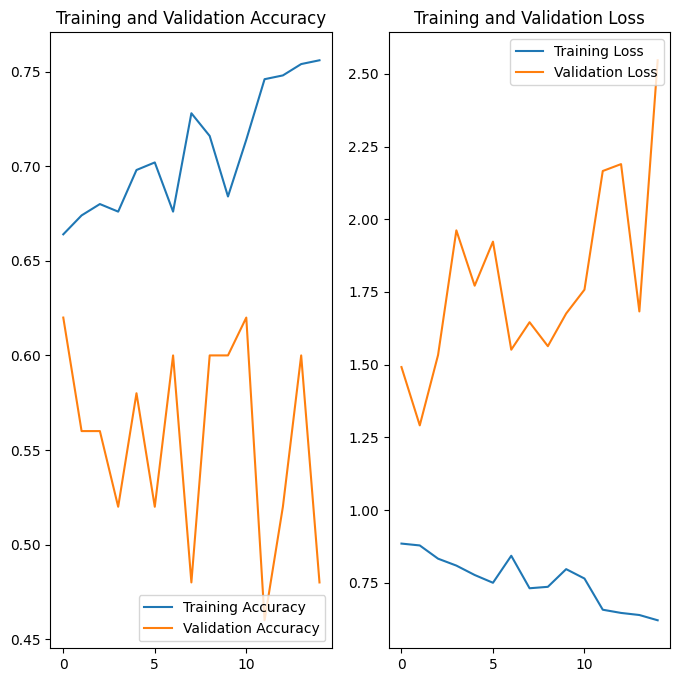

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Building Previous Model (after dealing with overfitting)

In [30]:
import pathlib
data_dir = pathlib.Path('/home/DataSet').with_suffix('')      # directory that stores the training data

# image count
imageCount = len(list(data_dir.glob('*/*.jpg')))

## Preprocessing / Creating dataset

In [31]:
img_height = 180
img_width = 180

In [32]:
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 5 classes.


In [33]:
# Identifying class names that model has to train for. These the species the user selected to train on.
class_names = train_ds.class_names
print(class_names)

['Falco_peregrinus_images', 'Oryx_gazella_images', 'Panthera_leo_images', 'Rattus_rattus_images', 'Zalophus_wollebaeki_images']


In [34]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [35]:
# Creating the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/val',
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 50 files belonging to 5 classes.


## Configuring dataset for performance

In [36]:
# Prefetching and caching the datasets to memory
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standarise data

RGB channel values are in the range `[0,255]`. But this is not ideal for NN, so need to make input values small.

Use `tf.keras.layers.Rescaling` to standardise values to `[0,1]` range.

In [37]:
normalization_layer = layers.Rescaling(1./255)

### Changing validation split images from 2:1 to 1:1 ratio images


In [38]:
from PIL import Image
import os,sys

In [39]:
# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(imagesArchive, 'r')

except IOError as e:
  print(e)

else:

  for id,value in annotatedFiles.items():
    # create image file path
    imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"
    imgToExtract.append(imgFilePath)

  t.extractall('/home/val2.0', members=imgToExtract)      # download the new images to another folder


### Cropping the validation images

In [40]:
# rename all folders
path = '/home/val2.0/val'
dirs = os.listdir(path)

for folder in dirs:
  # rename folders so class folders match the names of the training dataset
  os.rename(f"{path}/{folder}", f"{path}/{'_'.join(folder.split('_')[6::])}_images")

  # get new path to manipulate images
  new_path = f"{path}/{'_'.join(folder.split('_')[6::])}_images"
  image_dir = os.listdir(new_path)

  for item in image_dir:
    # full image path
    item_path = f"{new_path}/{item}"

    if os.path.isfile(item_path):
      print(f"Currently manipulating {item}")
      im = Image.open(item_path)

      # cropping the images to square aspect ratio
      width, height = im.size
      min_dimension = min(width, height)
      # left(x), upper(y), right(x), lower(y)
      img_mid_area = ((width - min_dimension) // 2,
                      (height - min_dimension) // 2,
                      ((width - min_dimension) // 2) + min_dimension,
                       ((height - min_dimension) // 2) + min_dimension)
      img_cropped = im.crop(img_mid_area)

      # resize square cropped images to 180x180px
      imResize = img_cropped.resize((180,180))

      imResize.save(item_path,'JPEG', quality=90)


Currently manipulating ae9adbce-1809-4263-8737-020aee79e657.jpg
Currently manipulating b0f0d610-5aba-4df0-86ed-6594e43b567f.jpg
Currently manipulating 4c0bfdd5-816c-45f4-b637-89d06f7ee157.jpg
Currently manipulating ca25da17-453a-472f-b0b1-8c46a36b2948.jpg
Currently manipulating 5dcbbcf8-e1b8-400b-b834-5c1e86885cff.jpg
Currently manipulating 25b3ef16-2528-409f-ba37-0b4e0bb92d2d.jpg
Currently manipulating bcbf1577-1003-4103-8f52-5cea72d5cd96.jpg
Currently manipulating 83b87a73-0f1c-4bf0-9220-86d5789626d9.jpg
Currently manipulating 300262a5-cf42-4296-ad50-d9d305e19a80.jpg
Currently manipulating 8eb3b671-6ff9-4e0f-8367-4751570621e7.jpg
Currently manipulating 10336fc9-ee73-483d-9db0-19cc30090ab7.jpg
Currently manipulating e33a4cfe-7148-4f37-8b42-f377409f2027.jpg
Currently manipulating 0fd3c3c8-07bf-40b9-9e18-d2f33e1a9993.jpg
Currently manipulating 1fb38970-a060-44bc-a8e5-6943d4c8a194.jpg
Currently manipulating fa96b055-cead-46a8-9db7-68c1b95a0c9d.jpg
Currently manipulating 1e1ab9ab-a871-486

## Dropout and Data augmentation

### Data augmentation

In [41]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

View augmented examples:

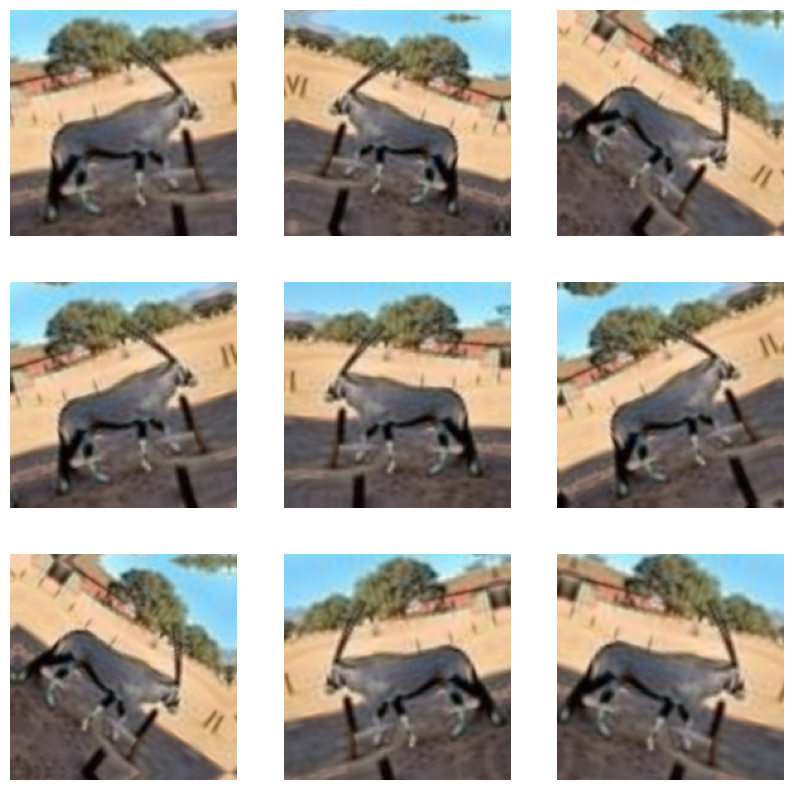

In [42]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [53]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUM_CLASSES, name="outputs")
])

### Compile and training the new tuned model

In [54]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [56]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
16/16 [==============================] - 20s 1s/step - loss: 1.6559 - accuracy: 0.2380 - val_loss: 1.4818 - val_accuracy: 0.4600
Epoch 2/15
16/16 [==============================] - 18s 1s/step - loss: 1.4403 - accuracy: 0.3900 - val_loss: 1.2139 - val_accuracy: 0.5000
Epoch 3/15
16/16 [==============================] - 19s 1s/step - loss: 1.3477 - accuracy: 0.3900 - val_loss: 1.1459 - val_accuracy: 0.5200
Epoch 4/15
16/16 [==============================] - 20s 1s/step - loss: 1.2813 - accuracy: 0.4600 - val_loss: 1.1688 - val_accuracy: 0.5400
Epoch 5/15
16/16 [==============================] - 19s 1s/step - loss: 1.2412 - accuracy: 0.4800 - val_loss: 1.2274 - val_accuracy: 0.4800
Epoch 6/15
16/16 [==============================] - 19s 1s/step - loss: 1.1404 - accuracy: 0.5380 - val_loss: 1.3301 - val_accuracy: 0.4600
Epoch 7/15
16/16 [==============================] - 18s 1s/step - loss: 1.0864 - accuracy: 0.5760 - val_loss: 1.1516 - val_accuracy: 0.6200
Epoch 8/15
16/16 [==

## Visualise training results

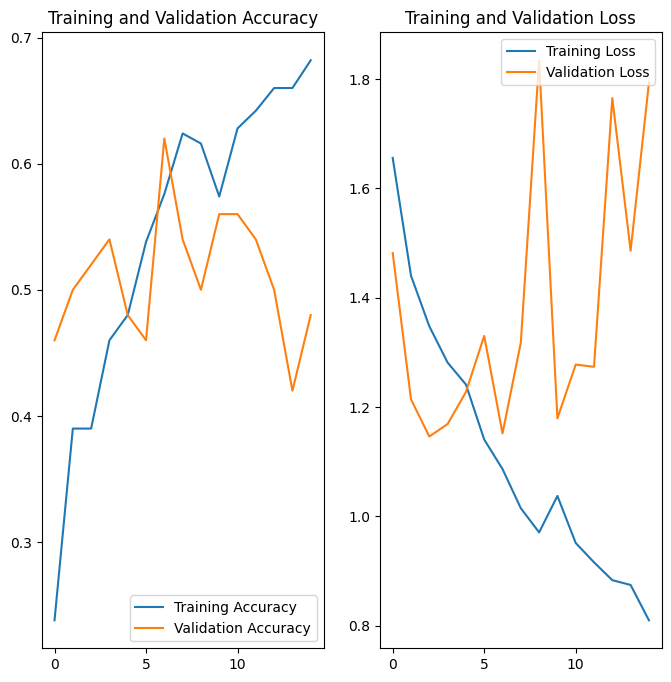

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Comparison

By looking at the Training and Validaion Accuracy graphs of both the previous model and EfficientNetB0, it appears that EfficientNetB0 performs only slightly better than its counterpart. Though I think due to the previously mentioned problems with the dataset may had an effect on this score. Not, only that, not much training data was used.

If later versions of EfficientNet were used, like EfficientNetB7, the score accuracy might have been better than what it is now.

Also, the training of EfficientNetB0 was copied from here: https://github.com/vatsaldpatel/EfficientNet-Transfer-Learning, which may be outdated but I could not find a better resource. This may have played a role in the unsurprising accuracy score.